In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from utils import *
PATH = "/Users/danil/BSE/Tesis/dataSent12_21Good/"
companies_ranked = pd.read_csv(PATH + "CompaniesrankedMarketCap.csv")
big_sent_all = pd.read_csv(PATH + "USbig_Sent12_21.csv")
big_sent_all = pd.DataFrame(big_sent_all)[["date", "stock", "linscr"]]
med_sent_all = pd.read_csv(PATH + "USmed_Sent12_21.csv")
med_sent_all = pd.DataFrame(med_sent_all)[["date", "stock", "linscr"]]
small_sent_all = pd.read_csv(PATH  + "USsmall_Sent12_21.csv")
small_sent_all = pd.DataFrame(small_sent_all)[["date", "stock", "linscr"]]

In [2]:
big_sent_all

,date,stock,linscr
0,2012-01-04T00:00:00Z,AAL,75.0419
1,2012-01-05T00:00:00Z,AAL,53.3333
2,2012-01-06T00:00:00Z,AAL,74.3750
3,2012-01-07T00:00:00Z,AAL,70.9177
4,2012-01-08T00:00:00Z,AAL,0.0000
...,...,...,...
289496,2021-11-27T00:00:00Z,ET,0.0000
289497,2021-11-28T00:00:00Z,ET,0.0000
289498,2021-11-29T00:00:00Z,ET,0.0000
289499,2021-11-30T00:00:00Z,ET,0.0000


In [3]:
big_sent_pivot = big_sent_all.pivot(index="date", columns="stock", values= "linscr")
big_sent_pivot

stock,AAL,AAPL,ABBV,ABC,ABT,ADP,AIG,AMD,AMZN,AXP,...,UAL,UNH,UPS,USB,V,VZ,WFC,WMT,WY,XOM
date,,,,,,,,,,,,,,,,,,,,,
2012-01-02T00:00:00Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,10.9553,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2807
2012-01-03T00:00:00Z,NaN,15.0997,NaN,83.3333,17.1028,NaN,NaN,NaN,NaN,NaN,...,35.7657,NaN,NaN,100.0000,NaN,14.2857,53.8188,14.2857,NaN,2.2519
2012-01-04T00:00:00Z,75.0419,56.3951,NaN,66.7830,17.3095,47.9782,18.0340,57.2778,64.4571,77.0397,...,47.1125,0.0000,66.7323,61.1930,100.0000,41.5813,0.0000,21.4437,0.0000,14.3610
2012-01-05T00:00:00Z,53.3333,60.5574,NaN,43.1752,52.4642,8.6337,88.0108,60.1085,19.9874,65.6233,...,43.1721,0.0000,78.4615,89.2930,0.0000,51.3410,51.3178,28.2662,69.4719,14.4794
2012-01-06T00:00:00Z,74.3750,58.7690,NaN,90.0332,50.0000,39.9165,69.7269,100.0000,52.5774,30.1755,...,28.7344,68.7500,0.0000,76.0074,0.0000,36.2199,17.2306,39.2602,NaN,21.1067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27T00:00:00Z,20.3302,54.3086,75.7296,51.7157,64.4993,0.0000,58.3012,73.7678,30.2219,10.0723,...,15.6070,NaN,19.9309,42.9630,NaN,0.0000,20.4201,54.6990,0.0000,0.0000
2021-11-28T00:00:00Z,38.0634,55.4475,NaN,NaN,NaN,NaN,NaN,83.5694,54.2548,NaN,...,16.4894,100.0000,8.3744,NaN,NaN,33.3500,0.0000,65.2119,NaN,NaN
2021-11-29T00:00:00Z,44.3530,NaN,NaN,35.9823,NaN,NaN,NaN,100.0000,14.0921,20.0000,...,30.7571,NaN,8.3744,100.0000,NaN,NaN,0.0000,39.7059,NaN,NaN


We check viable stocks with less than 20% missing values. We note that there aren't many (28) from the original 108. Next we want to know if we remove some consecutive early years, we get a lower proportion of NaN's.

In [4]:
get_viable_stocks(big_sent_pivot, 0.2).shape

(28,)

By removing the first 3 years we only improve by one stocks, which means that the missing values are relatively uniformlly distributed.

In [5]:
remove_years(big_sent_pivot, 3, 0.2).shape


(30,)

We could be more flexible with our tolerance for NaNs and cosider stocks with at most 25% which brings us up to 44.

In [6]:
remove_years(big_sent_pivot, 0,0.25).shape

(44,)

We also want to check if at any given year there were more than 20% or 25% NaN's so we could only select the stocks that make sense. There are only 24 of these. This means that we need to either relax our missing data threshold or only work on fullish stocks. Notice that this is for big companies, smaller companies have less information.

In [7]:
viable_years(big_sent_pivot, 0.25).shape

(24,)

In [8]:
med_sent_pivot = med_sent_all.pivot(index="date", columns="stock", values= "linscr")
small_sent_pivot = small_sent_all.pivot(index="date", columns="stock", values= "linscr")
print("Shape of Medium sized companies: " + str(len(med_sent_pivot.columns)))
print("Shape of Small sized companies: " + str(len(small_sent_pivot.columns)))

Shape of Medium sized companies: 31
Shape of Small sized companies: 12


In [9]:
print("Viable stocks for Medium sized companies: " + str(len(get_viable_stocks(med_sent_all, 0.2))))
print("Viable stocks for Small sized companies: " + str(len(get_viable_stocks(small_sent_all, 0.2))))

Viable stocks for Medium sized companies: 3
Viable stocks for Small sized companies: 3


In [10]:
big_sent_pivot

stock,AAL,AAPL,ABBV,ABC,ABT,ADP,AIG,AMD,AMZN,AXP,...,UNH,UPS,USB,V,VZ,WFC,WMT,WY,XOM,Year
date,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.2807,2012
2012-01-03 00:00:00+00:00,NaN,15.0997,NaN,83.3333,17.1028,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,100.0000,NaN,14.2857,53.8188,14.2857,NaN,2.2519,2012
2012-01-04 00:00:00+00:00,75.0419,56.3951,NaN,66.7830,17.3095,47.9782,18.0340,57.2778,64.4571,77.0397,...,0.0000,66.7323,61.1930,100.0000,41.5813,0.0000,21.4437,0.0000,14.3610,2012
2012-01-05 00:00:00+00:00,53.3333,60.5574,NaN,43.1752,52.4642,8.6337,88.0108,60.1085,19.9874,65.6233,...,0.0000,78.4615,89.2930,0.0000,51.3410,51.3178,28.2662,69.4719,14.4794,2012
2012-01-06 00:00:00+00:00,74.3750,58.7690,NaN,90.0332,50.0000,39.9165,69.7269,100.0000,52.5774,30.1755,...,68.7500,0.0000,76.0074,0.0000,36.2199,17.2306,39.2602,NaN,21.1067,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-27 00:00:00+00:00,20.3302,54.3086,75.7296,51.7157,64.4993,0.0000,58.3012,73.7678,30.2219,10.0723,...,NaN,19.9309,42.9630,NaN,0.0000,20.4201,54.6990,0.0000,0.0000,2021
2021-11-28 00:00:00+00:00,38.0634,55.4475,NaN,NaN,NaN,NaN,NaN,83.5694,54.2548,NaN,...,100.0000,8.3744,NaN,NaN,33.3500,0.0000,65.2119,NaN,NaN,2021
2021-11-29 00:00:00+00:00,44.3530,NaN,NaN,35.9823,NaN,NaN,NaN,100.0000,14.0921,20.0000,...,NaN,8.3744,100.0000,NaN,NaN,0.0000,39.7059,NaN,NaN,2021


In [24]:
three = get_weekly_stocks(big_sent_pivot, 3)
three

Year  Week
2012  1        63
      2        99
      3        98
      4       102
      5       101
             ... 
2021  45      107
      46      107
      47      100
      48      108
      53      108
Length: 520, dtype: int64

In [29]:
tolerance = [0,1,2,3,4,5,6]

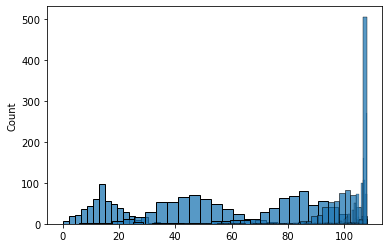

In [30]:
for i in tolerance:
    sns.histplot(get_weekly_stocks(big_sent_pivot, i))